In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import os

outdir = r'./eval/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
outdir = r'./eval/baseline'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [2]:
random_state = 23873

# dt = pd.read_excel(r'./data/CA_BC.xlsx').T
# dt.columns = dt.iloc[0]
# dt = dt.iloc[1:]
# dt['Label'] = dt.Label.map({'E':1,'A':0})

# dt.drop_duplicates(keep='first',inplace=True)


# unknown_counter = 1
# new_columns = []

# for column_name in dt.columns:
#     if not column_name or pd.isnull(column_name):
#         # Assign "unknown" followed by a number as the column name
#         new_columns.append(f"unknown_{unknown_counter}")
#         unknown_counter += 1
#     else:
#         new_columns.append(column_name)

# # Update the column names in the DataFrame
# dt.columns = new_columns

# for x in dt.select_dtypes(include=['object']).columns:
#     dt[x] = dt[x].astype('float64')
# dt.columns = [str(x) for x in dt.columns]
# dt = dt.select_dtypes(include=['float64','int64'])


# ## Handle Duplicate Columns

# # Columns to not rename
# excluded = dt.columns[~dt.columns.duplicated(keep=False)]

# # An incrementer
# import itertools
# inc = itertools.count().__next__

# # A renamer
# def ren(name):
#     return f"{name}{inc()}" if name not in excluded else name

# # Use inside rename()
# for x in range(0,2):
#     dt.rename(columns=ren,inplace=True)

In [3]:
dt = pd.read_csv(r'data/refined_data.csv')

In [4]:
from lazypredict.Supervised import LazyClassifier
features = dt.copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:34<00:00,  1.18s/it]


In [5]:
models.to_csv(os.path.join(outdir, 'model_eval_baseline.csv'))

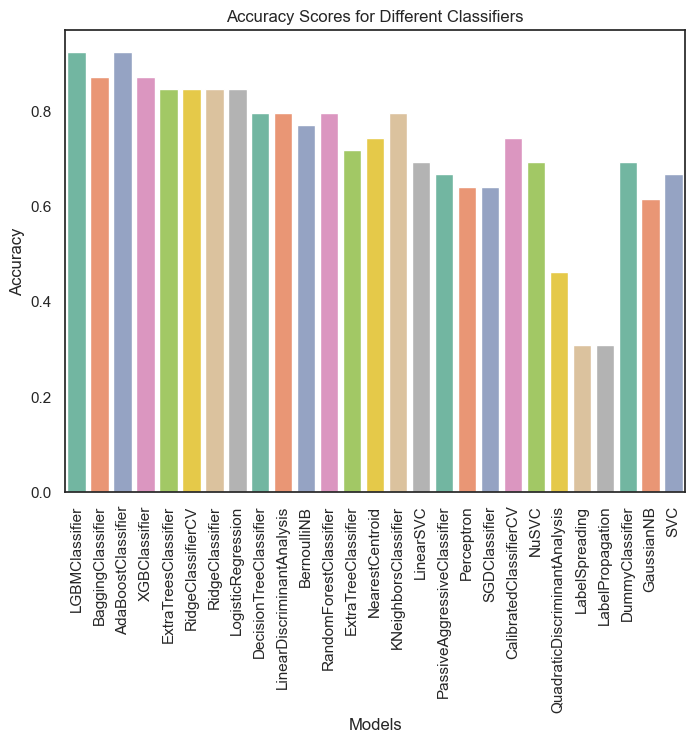

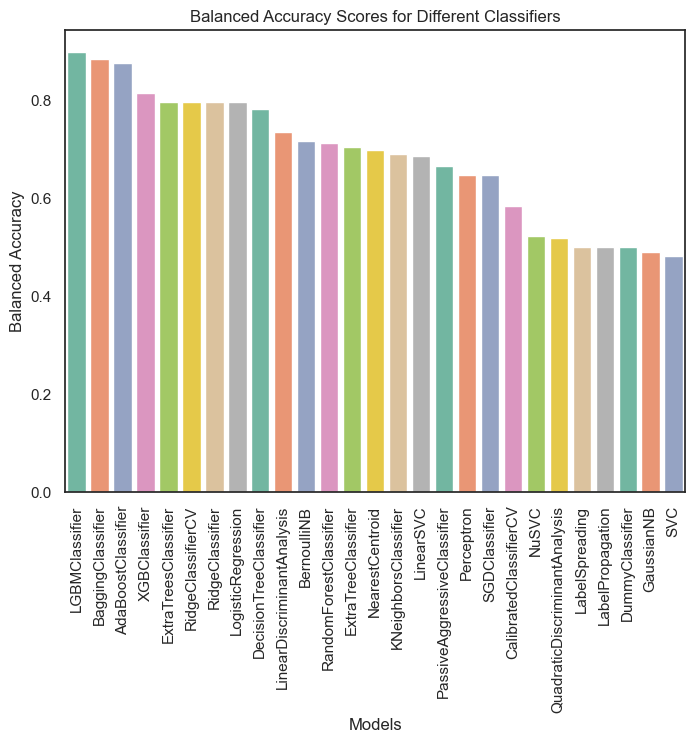

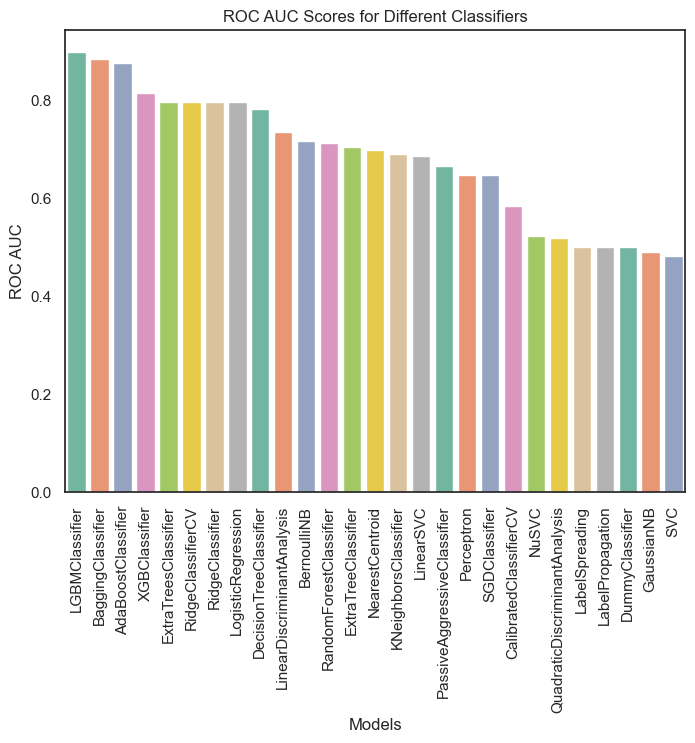

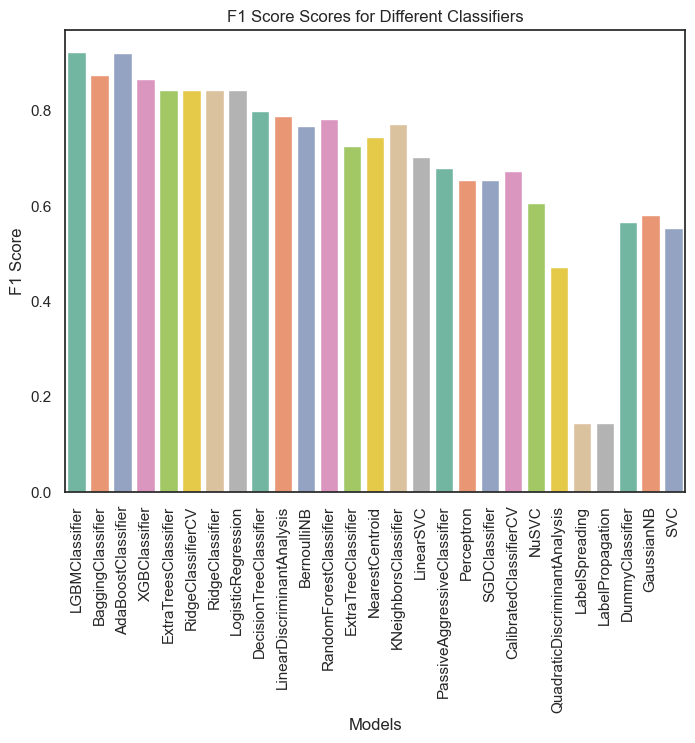

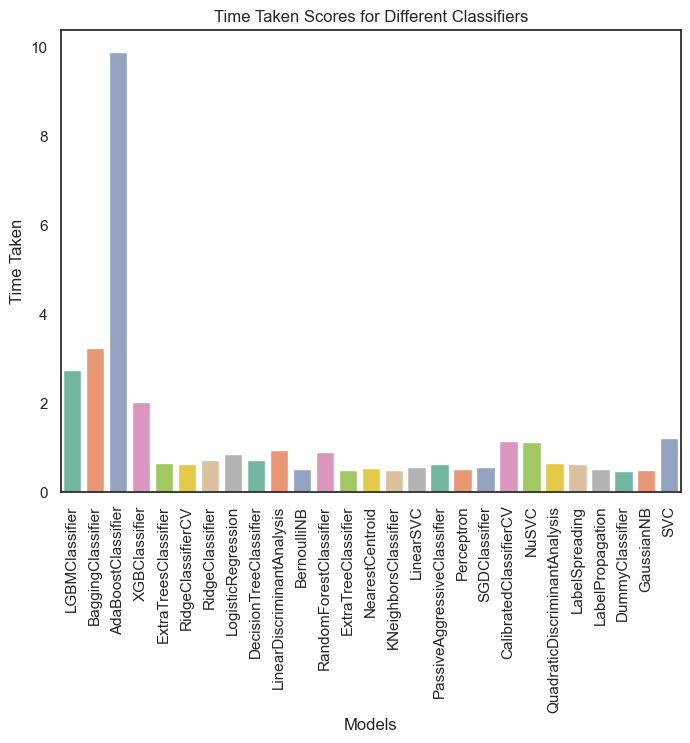

In [6]:
for x in models.columns:
    plt.figure(figsize=(8, 6))
    sns.set(style="white")
    sns.barplot(x=models.index, y=x, data=models,  palette="Set2")
    plt.title(f'{x} Scores for Different Classifiers')
    plt.xticks(rotation=90)
    plt.xlabel('Models')
    plt.ylabel(x)
    plt.savefig(os.path.join(outdir, f'Baseline_based_on_{x}.png'), dpi=300, bbox_inches='tight')
    plt.show()

### Remove Co-Linear Varaiables

In [7]:
# https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
corr = dt.corr()

# sns.heatmap(corr)

# Create correlation matrix
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Would drop {len(to_drop)} fields")

Would drop 912 fields


In [8]:
features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)

clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_min_max,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.06s/it]


In [9]:
models_min_max.to_csv(os.path.join(outdir, 'model_eval_scaled_dedup.csv'))

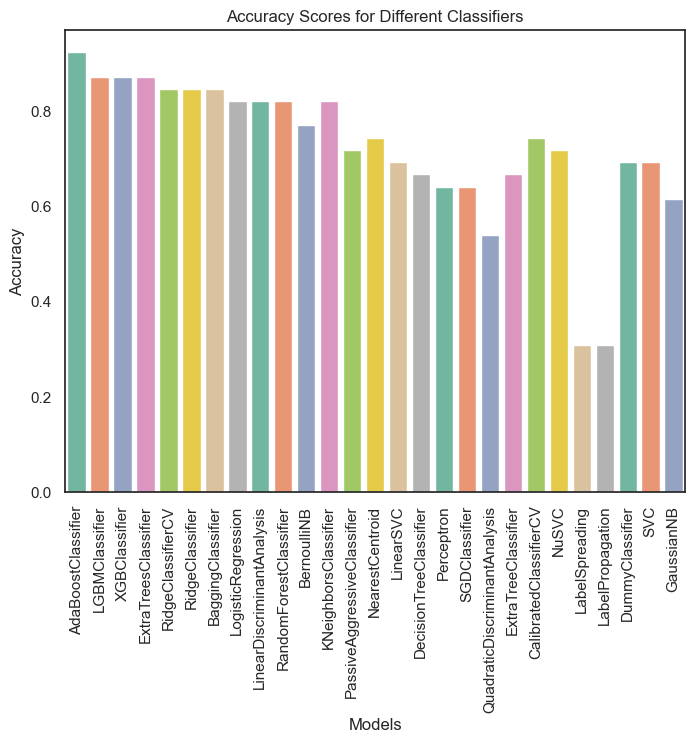

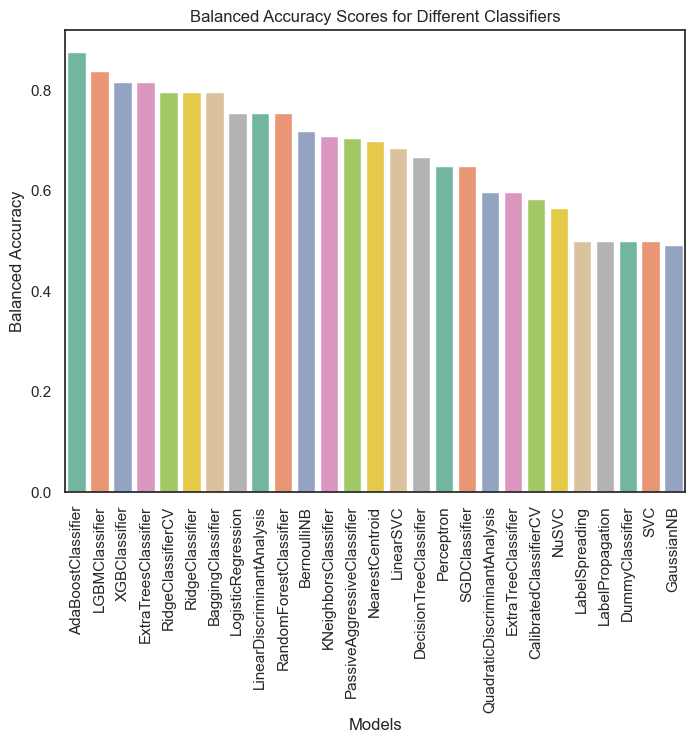

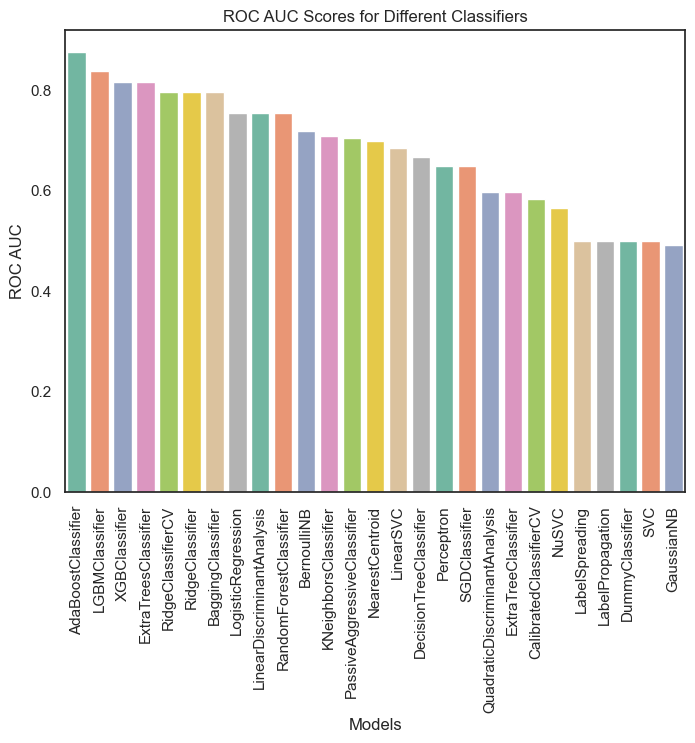

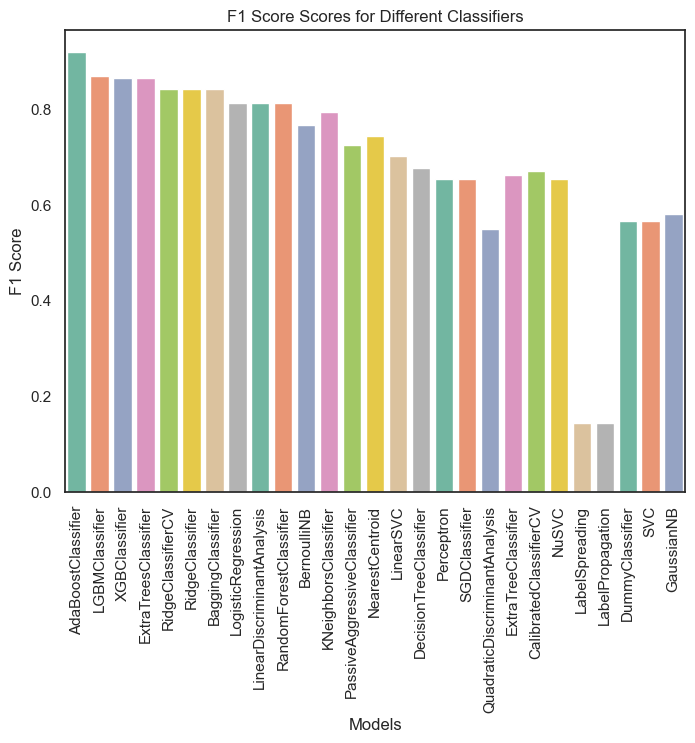

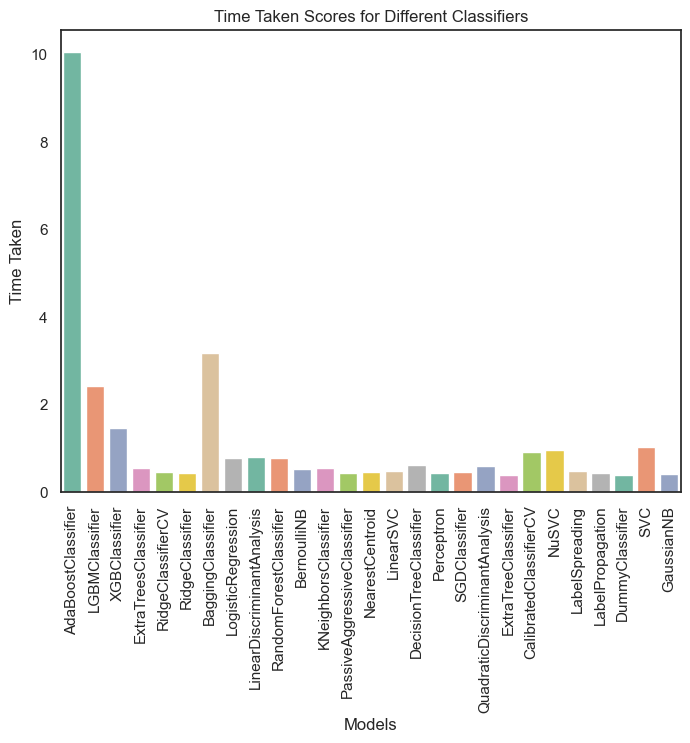

In [10]:
for x in models_min_max.columns:
    plt.figure(figsize=(8, 6))
    sns.set(style="white")
    sns.barplot(x=models_min_max.index, y=x, data=models_min_max,  palette="Set2")
    plt.title(f'{x} Scores for Different Classifiers')
    plt.xticks(rotation=90)
    plt.xlabel('Models')
    plt.ylabel(x)
    plt.savefig(os.path.join(outdir, f'Baseline_scaled_dedup_based_on_{x}.png'), dpi=300, bbox_inches='tight')
    plt.show()

### Difference Plot

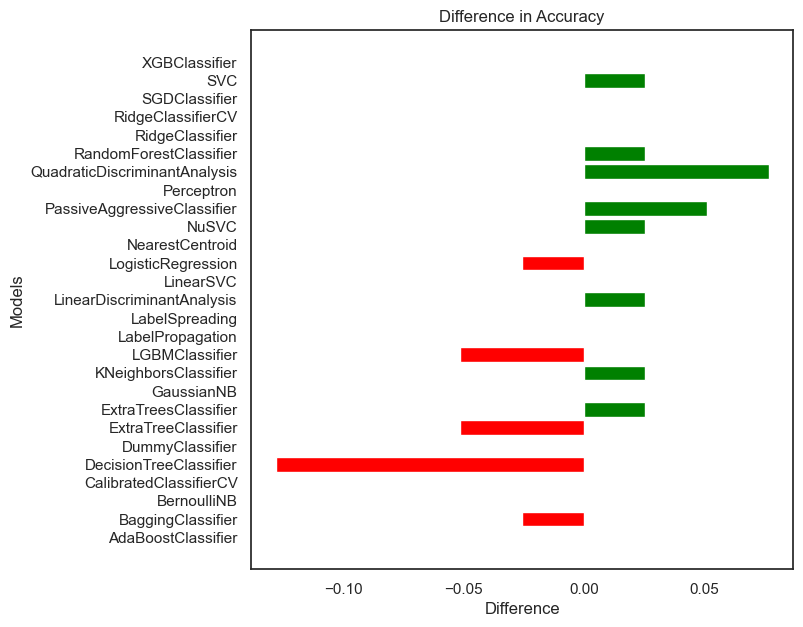

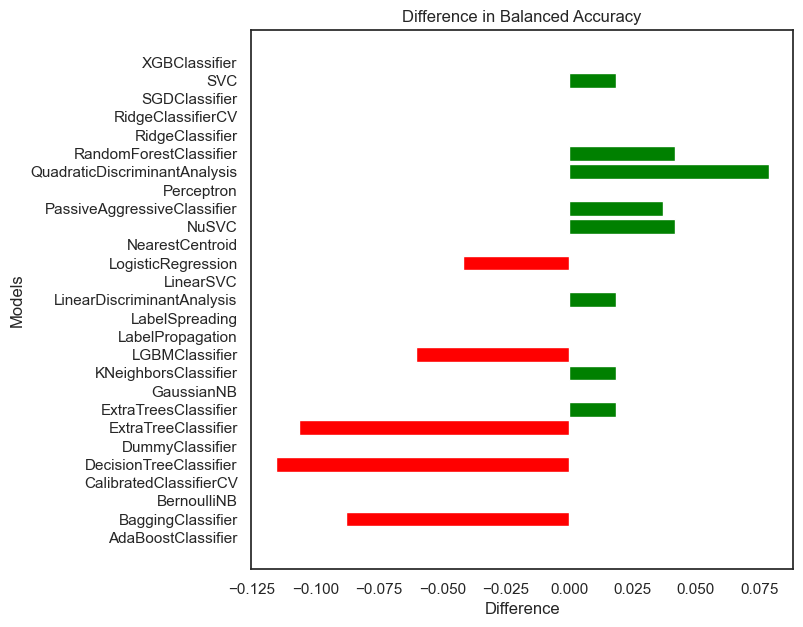

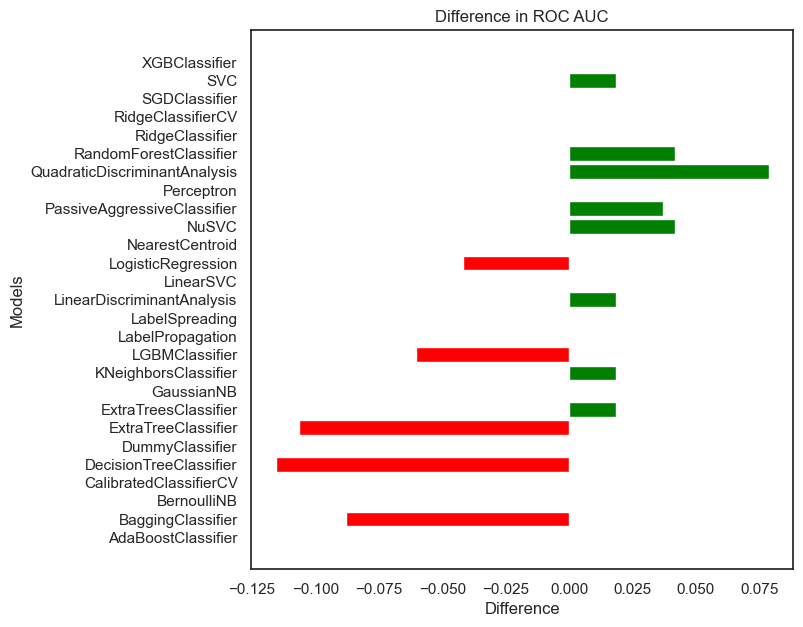

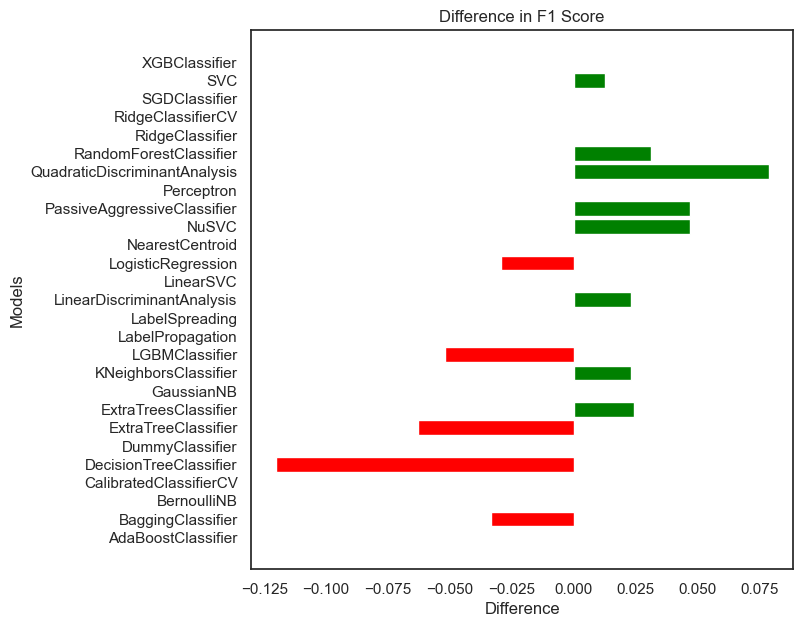

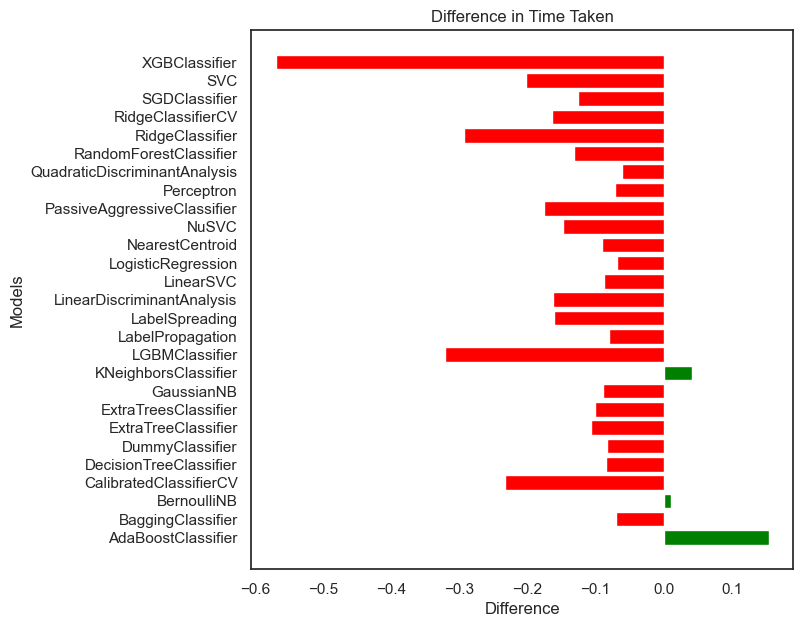

In [11]:
for x in models.columns:
    # Calculate the difference between the two dataframes
    diff = models_min_max.sort_index()[x] - models.sort_index()[x]

    # Set the color map
    colors = ['red' if d < 0 else 'green' for d in diff]

    # Create the horizontal bar plot
    plt.figure(figsize=(7, 7))
    plt.barh(models.sort_index().index, diff, color=colors)

    # Add labels and title
    plt.xlabel('Difference')
    plt.ylabel('Models')
    plt.title(f'Difference in {x}')
    plt.savefig(os.path.join(outdir, f"Baseline_scaled_{'_'.join(x.split(' '))}_diff.png"), dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()


In [12]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.92,0.90,0.90,0.92,2.75
BaggingClassifier,0.87,0.88,0.88,0.88,3.24
AdaBoostClassifier,0.92,0.88,0.88,0.92,9.89
XGBClassifier,0.87,0.81,0.81,0.87,2.04
ExtraTreesClassifier,0.85,0.80,0.80,0.84,0.66
RidgeClassifierCV,0.85,0.80,0.80,0.84,0.63
RidgeClassifier,0.85,0.80,0.80,0.84,0.73
LogisticRegression,0.85,0.80,0.80,0.84,0.86
DecisionTreeClassifier,0.79,0.78,0.78,0.80,0.71
